# **Import Packages**

In [39]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# **Import Data from CSV to DataFrame**

In [40]:
df = pd.read_csv('Online Retail Data.csv', header=0)
df

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN
...,...,...,...,...,...,...,...
461768,539991,21618,4 WILDFLOWER BOTANICAL CANDLES,1,2010-12-23 16:49:00,1.25,NaN
461769,539991,72741,GRAND CHOCOLATECANDLE,4,2010-12-23 16:49:00,1.45,NaN
461770,539992,21470,FLOWER VINE RAFFIA FOOD COVER,1,2010-12-23 17:41:00,3.75,NaN
461771,539992,22258,FELT FARM ANIMAL RABBIT,1,2010-12-23 17:41:00,1.25,NaN


# **Data Cleaning**

In [41]:
df_clean = df.copy()

# Create a date column
df_clean['date'] = pd.to_datetime(df_clean['order_date']).dt.date

# Removes all rows without product_name
df_clean = df_clean[~df_clean['product_name'].isna()]

# Make all product_names lowercase
df_clean['product_name'] = df_clean['product_name'].str.lower()

# Removes all rows with product_code or product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]

# Create an order_status column with the value 'cancelled' if the order_id begins with the letter 'c' and 'delivered' if the order_id does not begin with the letter 'c'
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')

# Change the negative quantity value to positive because the negative value only indicates that the order was cancelled
df_clean['quantity'] = df_clean['quantity'].abs()

# Delete rows with negative prices
df_clean = df_clean[df_clean['price']>0]

# Create an amount value, namely the product of quantity and price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']

# Replace the product_name of a product_code that has several product_names with one of the product_names that appears most frequently
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')

# Convert customer_id to string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)

# Removing outliers
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean

<ipython-input-41-98ced2442aa4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['product_name'] = df_clean['product_name'].str.lower()
<ipython-input-41-98ced2442aa4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['amount'] = df_clean['quantity'] * df_clean['price']


,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,cancelled,4.25
1,493413,21724,panda and bunnies sticker sheet,1,2010-01-04 09:54:00,0.85,nan,2010-01-04,delivered,0.85
2,493413,84578,elephant toy with blue t-shirt,1,2010-01-04 09:54:00,3.75,nan,2010-01-04,delivered,3.75
3,493413,21723,alphabet hearts sticker sheet,1,2010-01-04 09:54:00,0.85,nan,2010-01-04,delivered,0.85
4,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,delivered,91.80
...,...,...,...,...,...,...,...,...,...,...
455491,539991,21618,4 wildflower botanical candles,1,2010-12-23 16:49:00,1.25,nan,2010-12-23,delivered,1.25
455492,539991,72741,grand chocolatecandle,4,2010-12-23 16:49:00,1.45,nan,2010-12-23,delivered,5.80
455493,539992,21470,flower vine raffia food cover,1,2010-12-23 17:41:00,3.75,nan,2010-12-23,delivered,3.75
455494,539992,22258,felt farm animal rabbit,1,2010-12-23 17:41:00,1.25,nan,2010-12-23,delivered,1.25


In [42]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455496 entries, 0 to 455495
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      455496 non-null  object 
 1   product_code  455496 non-null  object 
 2   product_name  455496 non-null  object 
 3   quantity      455496 non-null  int64  
 4   order_date    455496 non-null  object 
 5   price         455496 non-null  float64
 6   customer_id   455496 non-null  object 
 7   date          455496 non-null  object 
 8   order_status  455496 non-null  object 
 9   amount        455496 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 34.8+ MB


# **Exploratory Data Analysis**

## Data Visualization

### Pivot Table

In [43]:
# Create a pivot table visualization
pd.pivot_table(df_clean, index='date',
               columns='order_status', values=['order_id','amount'],
               aggfunc={'order_id': pd.Series.nunique,
                        'amount': np.sum},
               fill_value=0
)

amount            order_id          
order_status cancelled delivered cancelled delivered
date                                                
2010-01-04      250.36   7866.41        11        26
2010-01-05       96.95  15529.29         4        33
2010-01-06        0.00   7430.34         0        13
2010-01-07      649.87  17506.10        32        40
2010-01-08       21.90  13404.25         1        36
...                ...       ...       ...       ...
2010-12-19       17.60   6653.94         2        21
2010-12-20      986.42  21149.55        24        54
2010-12-21      206.15  24229.66        10        47
2010-12-22       65.40   3690.45         5        13
2010-12-23      207.85   9767.24         8        24

[298 rows x 4 columns]

### Bar Chart

In [44]:
df_status_summary = df_clean.groupby('order_status', as_index=False).agg(order_cnt=('order_id','nunique'),total_amount=('amount','sum'))
df_status_summary

,order_status,order_cnt,total_amount
0,cancelled,3746,158184.030
1,delivered,17925,6932842.013


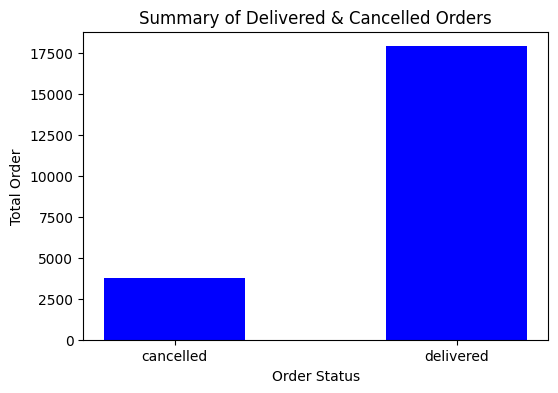

In [45]:
# Create a visualization of total delivered and cancelled orders (vertical bar chart)
fig = plt.figure(figsize=(6, 4))
plt.bar(df_status_summary['order_status'], df_status_summary['order_cnt'],
        color='blue', width=0.5)
plt.xlabel('Order Status')
plt.ylabel('Total Order')
plt.title('Summary of Delivered & Cancelled Orders')
plt.show()

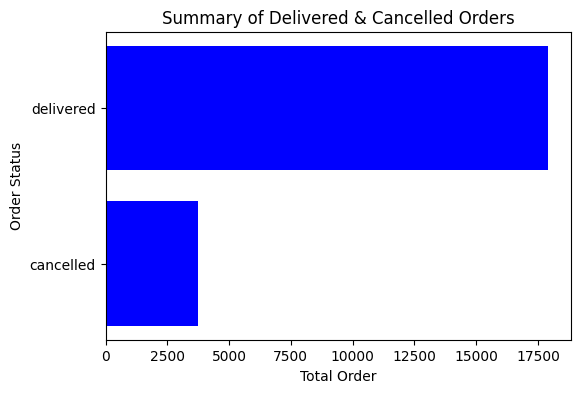

In [46]:
# Create a visualization of total delivered and cancelled orders (horizontal bar chart)
fig = plt.figure(figsize=(6, 4))
plt.barh(df_status_summary['order_status'], df_status_summary['order_cnt'],
         color='blue')
plt.xlabel('Total Order')
plt.ylabel('Order Status')
plt.title('Summary of Delivered & Cancelled Orders')
plt.show()

### Histogram

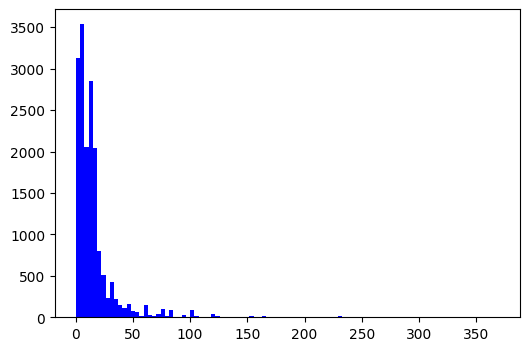

In [47]:
# Create a visualization of product data distribution that contains the word 'tea'
fig = plt.figure(figsize=(6, 4))
plt.hist(df_clean.loc[df_clean['product_name'].str.contains('tea'), 'amount'], 100,
         color='blue')
plt.show()

### Line Chart

In [48]:
df_date_summary = df_clean.groupby('date', as_index=False).agg(order_cnt=('order_id','nunique'))
df_date_summary

,date,order_cnt
0,2010-01-04,37
1,2010-01-05,37
2,2010-01-06,13
3,2010-01-07,72
4,2010-01-08,37
...,...,...
293,2010-12-19,23
294,2010-12-20,78
295,2010-12-21,57
296,2010-12-22,18


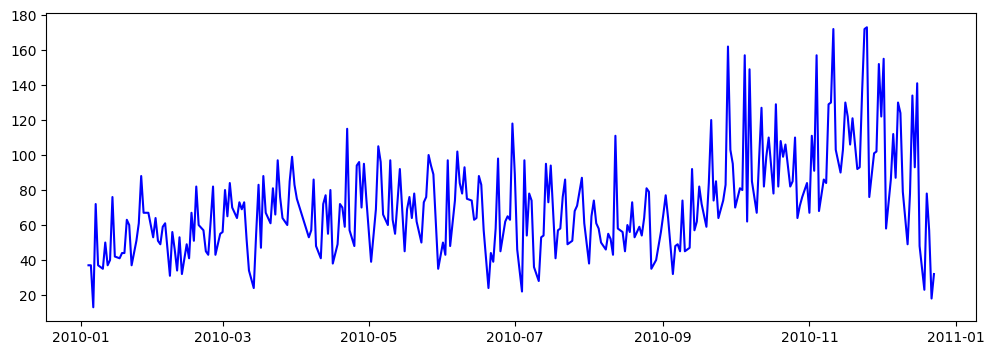

In [49]:
# Create a line chart visualization of total orders over time
fig = plt.figure(figsize=(12, 4))
plt.plot('date', 'order_cnt', data=df_date_summary, color='blue', linestyle='-')
plt.show()

### Pie Chart

In [50]:
df_status_summary

,order_status,order_cnt,total_amount
0,cancelled,3746,158184.030
1,delivered,17925,6932842.013


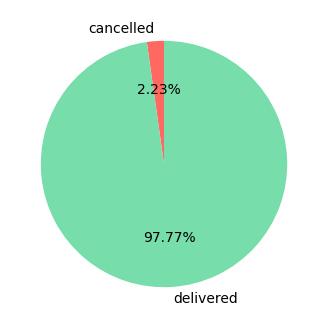

In [51]:
# Create a visualization of total orders with delivered and cancelled status in the form of a pie chart
fig = plt.figure(figsize=(6, 4))
plt.pie(df_status_summary['total_amount'], labels=df_status_summary['order_status'],
        startangle=90, autopct='%1.2f%%', colors=['#FF6961','#77DDAA'])
plt.show()

### Scatterplot

In [52]:
df_tea_only = df_clean[df_clean['product_name'].str.contains('tea')]
df_tea_only

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
8,493414,21527,red retrospot traditional teapot,12,2010-01-04 10:28:00,6.95,14590.0,2010-01-04,delivered,83.40
10,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,cancelled,23.85
20,493427,79000,moroccan tea glass,12,2010-01-04 10:43:00,0.85,13287.0,2010-01-04,delivered,10.20
56,C493430,21527,red retrospot traditional teapot,1,2010-01-04 11:43:00,7.95,14680.0,2010-01-04,cancelled,7.95
100,493432,22072,red retrospot tea cup and saucer,2,2010-01-04 12:30:00,3.75,14680.0,2010-01-04,delivered,7.50
...,...,...,...,...,...,...,...,...,...,...
455138,539958,22481,black tea towel classic design,3,2010-12-23 13:26:00,0.85,nan,2010-12-23,delivered,2.55
455196,539958,22900,set 2 tea towels i love london,1,2010-12-23 13:26:00,5.91,nan,2010-12-23,delivered,5.91
455467,539988,47559B,tea time oven glove,2,2010-12-23 16:06:00,1.25,18116.0,2010-12-23,delivered,2.50
455485,539991,22891,tea for one polkadot,1,2010-12-23 16:49:00,4.25,nan,2010-12-23,delivered,4.25


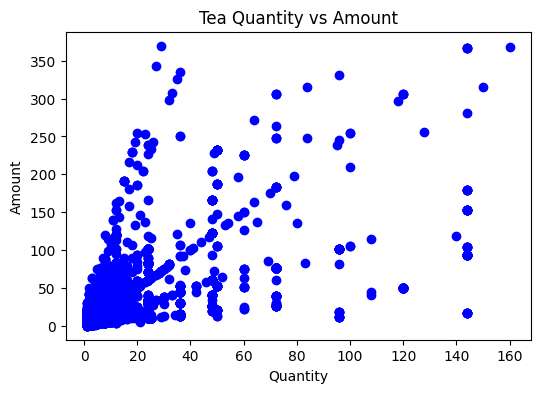

In [53]:
# Create a visualization to see the relationship between quantity of tea and amount
fig = plt.figure(figsize=(6, 4))
plt.scatter(df_tea_only['quantity'], df_tea_only['amount'], c='blue', marker='o')
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.title('Tea Quantity vs Amount')
plt.show()

### Boxplot

In [54]:
df_tea_only

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
8,493414,21527,red retrospot traditional teapot,12,2010-01-04 10:28:00,6.95,14590.0,2010-01-04,delivered,83.40
10,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,cancelled,23.85
20,493427,79000,moroccan tea glass,12,2010-01-04 10:43:00,0.85,13287.0,2010-01-04,delivered,10.20
56,C493430,21527,red retrospot traditional teapot,1,2010-01-04 11:43:00,7.95,14680.0,2010-01-04,cancelled,7.95
100,493432,22072,red retrospot tea cup and saucer,2,2010-01-04 12:30:00,3.75,14680.0,2010-01-04,delivered,7.50
...,...,...,...,...,...,...,...,...,...,...
455138,539958,22481,black tea towel classic design,3,2010-12-23 13:26:00,0.85,nan,2010-12-23,delivered,2.55
455196,539958,22900,set 2 tea towels i love london,1,2010-12-23 13:26:00,5.91,nan,2010-12-23,delivered,5.91
455467,539988,47559B,tea time oven glove,2,2010-12-23 16:06:00,1.25,18116.0,2010-12-23,delivered,2.50
455485,539991,22891,tea for one polkadot,1,2010-12-23 16:49:00,4.25,nan,2010-12-23,delivered,4.25


<Axes: ylabel='quantity'>

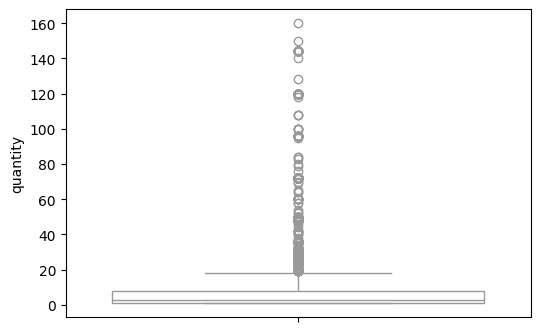

In [55]:
# Create a visualization to see outliers in the tea quantity data
fig = plt.figure(figsize=(6, 4))
sns.boxplot(data=df_tea_only, y='quantity', color='white')

<Axes: ylabel='amount'>

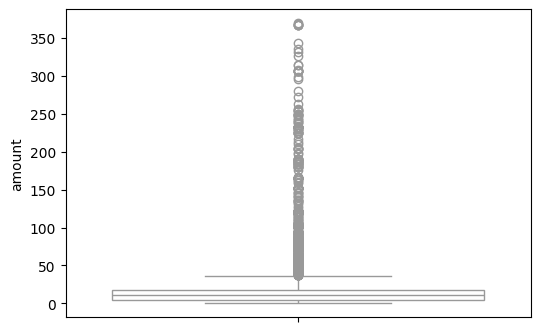

In [56]:
# Create a visualization to see outliers in the tea amount data
fig = plt.figure(figsize=(6, 4))
sns.boxplot(data=df_tea_only, y='amount', color='white')

## Correlation

### Heatmap

<ipython-input-57-908796d2ac5b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_clean.corr(), cmap='Blues', annot=True)


<Axes: >

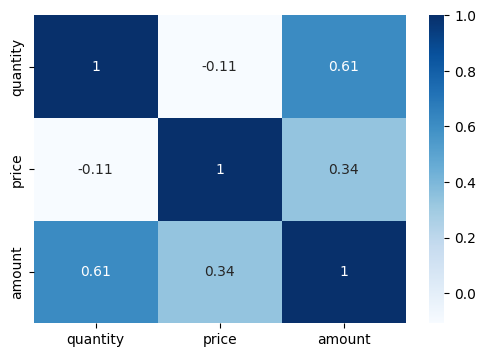

In [57]:
# Create a visualization to see the relationship between each column of numeric data
fig = plt.figure(figsize=(6, 4))
sns.heatmap(df_clean.corr(), cmap='Blues', annot=True)